In [1]:
import numpy as np
from numpy.random import normal
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from itertools import repeat

# Load and clean data

In [2]:
states = pd.read_excel("./messy_data/states.xlsx")
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)

In [3]:
states

,Jurisdiction,Jurisdiction Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,Florida,FL
9,Georgia,GA


In [4]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
malePrisonerPopulation.head()

,Jurisdiction,1978,1979,1980,1981,1982,1983,1984,1985,1986,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,Federal,27975.0,24835.0,22964.0,26574.0,28046.0,30172.0,32267.0,37819.0,41575.0,...,186280,188007,194493,196222,202462,203766,201697,196568,183502,176495
3,Alabama,5368.0,5221.0,6278.0,7339.0,8757.0,9375.0,9961.0,10453.0,11094.0,...,27254,28277,29419,29261,29696,29782,29660,29182,28220,26506
4,Alaska,678.0,729.0,801.0,977.0,1276.0,1557.0,1888.0,2207.0,2344.0,...,4603,4511,4696,4782,4932,4934,4450,5091,4761,4024
5,Arizona,3275.0,3573.0,4153.0,4986.0,5788.0,6566.0,7482.0,8134.0,8948.0,...,34286,35739,36768,36521,36470,36447,37402,38295,38738,38323
6,Arkansas,2553.0,2927.0,2805.0,3197.0,3755.0,4050.0,4286.0,4394.0,4477.0,...,13248,13656,14147,15040,14995,13594,15904,16476,16305,16161


In [5]:
def cleanPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

In [6]:
malePrisonerPopulation = cleanPopulationTable(malePrisonerPopulation, states)
malePrisonerPopulation.head()

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,5368.0,5221.0,6278.0,7339.0,8757.0,9375.0,9961.0,10453.0,...,27254,28277,29419,29261,29696,29782,29660,29182,28220,26506
1,Alaska,AK,678.0,729.0,801.0,977.0,1276.0,1557.0,1888.0,2207.0,...,4603,4511,4696,4782,4932,4934,4450,5091,4761,4024
2,Arizona,AZ,3275.0,3573.0,4153.0,4986.0,5788.0,6566.0,7482.0,8134.0,...,34286,35739,36768,36521,36470,36447,37402,38295,38738,38323
3,Arkansas,AR,2553.0,2927.0,2805.0,3197.0,3755.0,4050.0,4286.0,4394.0,...,13248,13656,14147,15040,14995,13594,15904,16476,16305,16161
4,California,CA,20178.0,21400.0,23253.0,27775.0,32987.0,37353.0,40892.0,47248.0,...,162654,162050,160286,155104,141382,128436,129684,129703,123808,124487


In [7]:
maleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
maleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Male").dropna().replace("/", np.nan)

In [8]:
def cleanCountTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

In [9]:
maleAdmission = cleanCountTable(maleAdmission, states)
maleRelease = cleanCountTable(maleRelease, states)

In [10]:
maleAdmission.head()

,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,2404.0,2382.0,3576.0,3773.0,4121.0,4283.0,4342.0,4013.0,...,9384,9683,11429,10341,9919,9683,9683,9391,8888,9155
1,Alaska,AK,250.0,303.0,449.0,430.0,502.0,681.0,697.0,840.0,...,NaN,NaN,NaN,2287,3090,3199,3199,3145,3131,1502
2,Arizona,AZ,1504.0,1559.0,1935.0,2594.0,2730.0,3088.0,3193.0,3755.0,...,12369,13129,12883,11708,11576,11486,12069,12747,12994,11933
3,Arkansas,AR,1851.0,2079.0,2192.0,2305.0,2182.0,2027.0,2034.0,2110.0,...,5938,6267,6596,6797,6346,5181,7939,8314,8112,8549
4,California,CA,11263.0,14245.0,13558.0,16835.0,20744.0,25195.0,26858.0,34620.0,...,125814,126768,117136,108157,88702,32103,35562,36025,32474,33232


In [11]:
maleRelease.head()

,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,2568.0,2519.0,3008.0,2677.0,2639.0,2923.0,3527.0,3377.0,...,9679,10128,10730,10572,9629,9794,9983,9928,9901,10895
1,Alaska,AK,229.0,208.0,248.0,258.0,324.0,484.0,473.0,593.0,...,2824,3183,2707,2645,2953,3080,3080,3080,2966,1826
2,Arizona,AZ,1220.0,1510.0,1353.0,1733.0,1879.0,2096.0,2344.0,3130.0,...,11202,11655,12279,11944,11589,11580,11507,11973,12497,12197
3,Arkansas,AR,1772.0,1771.0,2229.0,1946.0,1618.0,1765.0,1801.0,1987.0,...,5357,5854,6203,5952,6468,5646,5752,7759,8427,8943
4,California,CA,9194.0,12647.0,11574.0,12180.0,14998.0,20743.0,23279.0,27936.0,...,122328,123585,115944,110464,100001,43413,33996,35922,38322,32199


In [12]:
anualSentence = pd.read_excel("./messy_data/national sentencing.xlsx").iloc[:, [0,1]]
anualSentence.columns = ["Year", "Sentence"]
anualSentence.set_index("Year", inplace=True)
anualSentence = anualSentence.iloc[:-1,0]

Text(0, 0.5, 'Sentence')

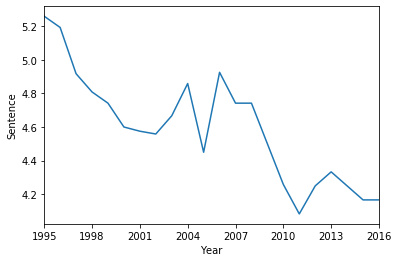

In [13]:
anualSentence.plot()
plt.xticks(np.array(range(1995, 2017, 3)))
plt.ylabel("Sentence")

# Model implementation

Using Texas data for example:

In [14]:
def extractStatePopulationCount(table, jurisdiction, tableType, year_begin=1978,year_end=2016):
    
    jurisdictions = table.Jurisdiction
    data = table.loc[jurisdictions==jurisdiction].iloc[0, 2:].astype(float)
    data = data.interpolate() # linear interpolation to fill in missing data
    data = data[np.logical_and(data.index <= year_end, data.index >= year_begin)]
    data.name = tableType
    data.index.name="Year"
    
    return data

In [15]:
jurisdiction = "Texas"

population = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population")
admission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission")
release = extractStatePopulationCount(maleRelease, jurisdiction, "Release")

Text(0, 0.5, 'Count')

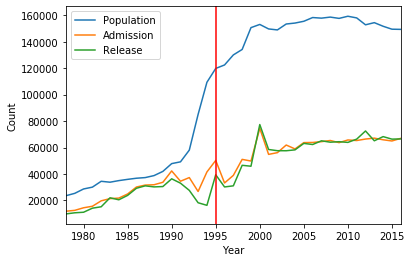

In [16]:
population.plot()
admission.plot()
release.plot()
plt.axvline(1995, color="red")
plt.legend()
plt.ylabel("Count")

## Build model

Estimate the error variance of prisoner population as increment of difference between admission and release.
The error is proportional to the previous year's population.
We use epsilon to denote this proportion, which is centered at **0**.

In [17]:
epsilon = (population.diff() - admission + release).values[1:] / population.values[:-1]

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'epsilon')

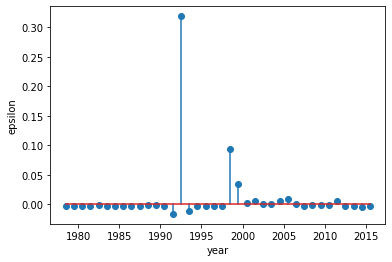

In [18]:
plt.stem(np.array(range(1979, 2017)) - 0.5, epsilon)
plt.xlabel("year")
plt.ylabel("epsilon")

In [19]:
epsilon_sd = epsilon.std()
epsilon_sd

0.05340514840437111

Given a certain year, we use a normal distribution to model the time remaining years to serve for a random prisoner in the population. For year __t__, the we use **mu[t]** to denote the center of this distribution. As the center varies as years go by, we force the variance, **sigma**, to be invariant.

In [20]:
modernPopulation = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population", 1995,2016)
modernAdmission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission", 1995,2016)
modernRelease = extractStatePopulationCount(maleRelease, jurisdiction, "Release", 1995,2016)

In [21]:
def extractInitialPopulation(table, jurisdiction):
    
    jurisdictions = table.Jurisdiction
    population = table.loc[jurisdictions==jurisdiction].iloc[0, 2:].astype(float)
    population = population.interpolate()
    initialPopulation = population[population.index == 1994]
    initialPopulation.name = "Population"
    initialPopulation.index.name="Year"
    
    return initialPopulation

As we have the admission and release data, provided the initial value of mu and population, we can propogate the state using an equation that represents the equilibrium **population x mu**.

In [22]:
initialPopulation = extractInitialPopulation(malePrisonerPopulation, jurisdiction)
initialPopulation

Year
1994    109356.0
Name: Population, dtype: float64

In [23]:
initialMu = 20

In [24]:
def propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y):
    # State propogation function
    return (past_p * (past_mu - 1) + 0.5 * current_r + current_a * current_y - 0.5 * current_a) / current_p


In [25]:
def solveMu(initialMu,initialPopulation, population, admission,release, anualSentence):
    # Given the initial state of mu and populatin,
    # this function can calculate the evolution of mu
    # according to the revolution of population, admission, release, and average sentence
    
    mu = population * 0
    mu.name = "Mu"

    
    for i, p in enumerate(population):
    
        if i == 0:
            past_p = initialPopulation.values
            past_mu = initialMu

        mu.iloc[i] = propogateMu(past_mu, past_p, population.iloc[i], admission.iloc[i],release.iloc[i], anualSentence.iloc[i])
        
        past_mu = mu.iloc[i]
        past_p = population.iloc[i]
        
    mu[1994] = initialMu
    mu.sort_index(inplace=True)
    
    return mu

In [26]:
mu = solveMu(initialMu,initialPopulation, modernPopulation, modernAdmission,modernRelease, anualSentence)

Text(0, 0.5, 'Mu')

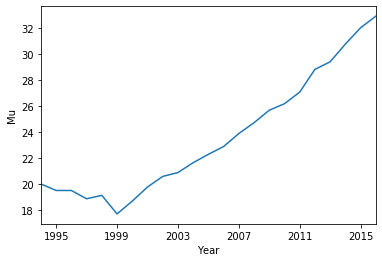

In [27]:
mu.plot()
plt.xticks(np.array(range(1995, 2016, 4)))
plt.ylabel("Mu")

We can model the anual release using the **CDF** of the above-mentioned normal distribution. The ratio of one year's release to the previous year's population should be **CDF(1 | mu[t-1], sigma)** given the previous year's **mu**. Using this relation, we can estimate the above-mentioned distribution's variance, and average over time to get a point estimation.

In [28]:
modernPopulation = pd.concat((initialPopulation, modernPopulation))

In [29]:
def estimateSigmaOfNormalCDF(x,F, mu):
    # This function can take vetor input
    
    # we have function F(x) as the CDF of N(mu, sigma^2)
    # given function Phi(x) as the CDF of N(0, 1)
    # F(x) = Phi((x - mu) / sigma)
    
    # the reverse function of Phi is norm.ppf()
    
    return (x - mu) / norm.ppf(F) 
    

In [30]:
def estimateSigma(population, release, mu):
    
    mu = mu.values[: -1]
    p = population.values[: -1]
    r = release.values

    
    F = r / p
    sigma = estimateSigmaOfNormalCDF(1,F, mu)
    sigma = sigma[sigma >= 0]
    
    return sigma.mean()

In [31]:
sigma = estimateSigma(modernPopulation, modernRelease, mu)
sigma

102.82270121156175

## Model projection

**Let's simulate one future trajectory.**

We can model the anual admission and the average sentence using a normal distribution, where the center is the last-reported data.

In [32]:
admissionSD = modernAdmission.std()
sentenceSD = anualSentence.std()

First, simulate the anual admission and average sentence

In [33]:
def sampleFutureAdmissionSentence(sampleMean,sampleSD, year_end, dataType):
    
    years = range(2017, year_end + 1)
    simulated = normal(sampleMean,sampleSD, len(years))
    if dataType == "Admission":
        simulated = np.round(simulated)
    
    simulated = pd.Series(simulated, index=years, name=dataType, dtype=int)
    simulated.index.name = "Year"
    
    return simulated

In [34]:
futureAdmission = sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission")
futureSentence = sampleFutureAdmissionSentence(anualSentence.iloc[-1],sentenceSD, 2050, "Sentence")

Given **mu[t-1]** and **sigma**, we can determine **release[t]** with **population[t-1]**.

Given **population[t-1]**, **admission[t]** and **release[t]**, we can sample **population[t]**.

Finally, we use function *propogateMu* to propogate the state of **mu[t]**

In [35]:
def propogateState(past_mu,past_p, current_a,current_y, epsilon_sd, sigma):
    
    current_r = round(norm(past_mu, sigma).cdf(1) * past_p)
    current_p = round(past_p + current_a - current_r + normal(scale=epsilon_sd) * past_p)
    current_mu = propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y)
    
    return current_mu, current_p, current_r
    

In [36]:
initialMu = mu.iloc[-1]
initialPopulation = modernPopulation.iloc[-1]

In [37]:
def solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma):
    
    futurePopulation = futureAdmission * 0
    futurePopulation.name = "Population"
    
    futureRelease = futureAdmission * 0
    futureRelease.name = "Release"
    
    futureMu = futureSentence *0
    futureMu.name = "Mu"
    
    for i, p in enumerate(futurePopulation):
        
        if i == 0:
            past_mu = initialMu
            past_p = initialPopulation
            
        futureMu.iloc[i], futurePopulation.iloc[i], futureRelease.iloc[i] = propogateState(past_mu,past_p, futureAdmission.iloc[i],futureSentence.iloc[i], epsilon_sd, sigma)
        
        past_mu = futureMu.iloc[i]
        past_p = futurePopulation.iloc[i]
        
    return futureMu, futurePopulation, futureRelease

In [38]:
futureMu, futurePopulation, futureRelease = solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma)

Text(0, 0.5, 'Count')

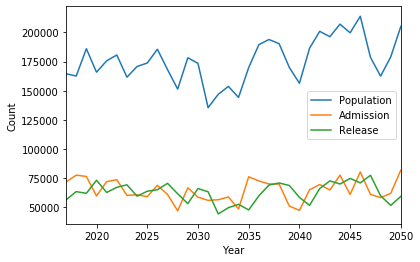

In [39]:
futurePopulation.plot()
futureAdmission.plot()
futureRelease.plot()
plt.legend()
plt.ylabel("Count")

Text(0, 0.5, 'Mu')

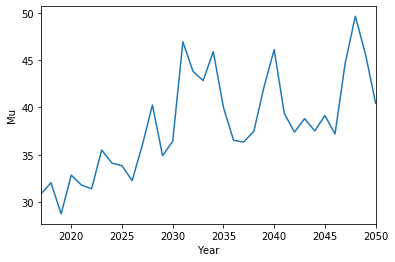

In [40]:
futureMu.plot()
plt.ylabel("Mu")

## Now let's generate and average a cluster of trajectories.

In [41]:
futureAdmissions = [sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2100, "Admission") for i in range(1000)]
futureSentences = [sampleFutureAdmissionSentence(anualSentence.iloc[-1],sentenceSD, 2100, "Sentence") for i in range(1000)]

futureMus, futurePopulations, futureReleases = zip(*map(solvePopulation, repeat(initialMu),repeat(initialPopulation), futureAdmissions,futureSentences, repeat(epsilon_sd), repeat(sigma)))


Text(0, 0.5, 'Mu')

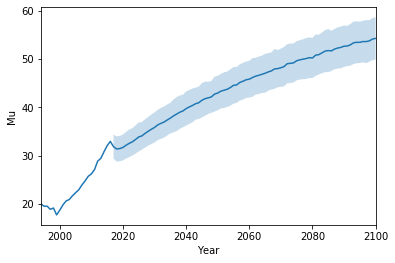

In [42]:
futureMu_mean = pd.concat(futureMus, axis=1).mean(axis=1)
futureMu_sd = pd.concat(futureMus, axis=1).std(axis=1)

pd.concat([mu, futureMu_mean]).plot()
plt.fill_between(futureMu_mean.index, futureMu_mean-futureMu_sd, futureMu_mean+futureMu_sd, alpha=0.25)
plt.ylabel("Mu")

In [43]:
futurePopulation_mean = pd.concat(futurePopulations, axis=1).mean(axis=1)
futurePopulation_mean.name = "Population"

futurePopulation_sd = pd.concat(futurePopulations, axis=1).std(axis=1)

In [44]:
futureAdmission_mean = pd.concat(futureAdmissions, axis=1).mean(axis=1)
futureAdmission_mean.name = "Admission"

futureAdmission_sd = pd.concat(futureAdmissions, axis=1).std(axis=1)

In [45]:
futureRelease_mean = pd.concat(futureReleases, axis=1).mean(axis=1)
futureRelease_mean.name = "Release"

futureRelease_sd = pd.concat(futureReleases, axis=1).std(axis=1)

Text(0, 0.5, 'Count')

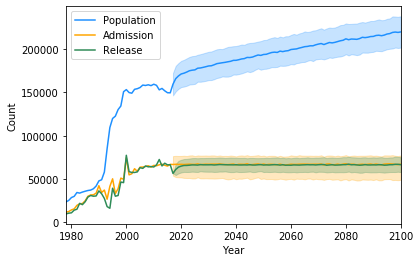

In [46]:
pd.concat([population, futurePopulation_mean]).plot(color="dodgerblue")
plt.fill_between(futurePopulation_mean.index, futurePopulation_mean - futurePopulation_sd, futurePopulation_mean + futurePopulation_sd, color="dodgerblue", alpha=0.25)

pd.concat([admission, futureAdmission_mean]).plot(color="orange")
plt.fill_between(futureAdmission_mean.index, futureAdmission_mean - futurePopulation_sd, futureAdmission_mean + futureAdmission_sd, color="orange", alpha=0.25)

pd.concat([release, futureRelease_mean]).plot(color="seagreen")
plt.fill_between(futureRelease_mean.index, futureRelease_mean - futureRelease_sd, futureRelease_mean + futureRelease_sd, color="seagreen", alpha=0.25)

plt.legend()
plt.ylabel("Count")

# Write a function for the complete routine

In [47]:
def modelAndProject(populationTable, admissionTable,releaseTable, jurisdiction, annualSentence, initialMu, projectionYear, N):
    
    # Note: the population, admission and release data range -- 1978-2017
    # the anual sentencing data range -- 1995-2016
    # N is the number of samples to draw for prediction
    # initialMu is the mu for 1994
    # projectionYear is the end of projection

    
    # Estimate error term of population increment
    
    population = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population")
    admission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission")
    release = extractStatePopulationCount(maleRelease, jurisdiction, "Release")
    # data range 1978-2017
    
    epsilon = (population.diff() - admission + release).values[1:] / population.values[:-1]
    epsilon_sd = epsilon.std()
    
    # Model state propogation
    
    modernPopulation = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population", 1995,2016)
    modernAdmission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission", 1995,2016)
    modernRelease = extractStatePopulationCount(maleRelease, jurisdiction, "Release", 1995,2016)
    # data range 1995-2016
    
    # estimate mu[t]
    initialPopulation = extractInitialPopulation(malePrisonerPopulation, jurisdiction) # use 1994 for initial population
    mu = solveMu(initialMu,initialPopulation, modernPopulation, modernAdmission,modernRelease, anualSentence)
    # solveMu already concates initial state of mu to the output
    
    # estimate sigma
    modernPopulation = pd.concat((initialPopulation, modernPopulation))
    # include the initial state of population

    sigma = estimateSigma(modernPopulation, modernRelease, mu)
    
    # Project to from 2017 to projectionYear
    
    # Model and sample N sets of future admission and sentence
    
    admissionMean = modernAdmission.mean()
    admissionSD = modernAdmission.std()
    futureAdmissions = [sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission") for i in range(N)]

    sentenceMean = anualSentence.mean()
    sentenceSD = anualSentence.std()
    futureSentences = [sampleFutureAdmissionSentence(anualSentence.iloc[-1],sentenceSD, 2050, "Sentence") for i in range(N)]
    
    # Project future mu, population and release
    
    futureMus, futurePopulations, futureReleases = zip(*map(solvePopulation, repeat(initialMu),repeat(initialPopulation), futureAdmissions,futureSentences, repeat(epsilon_sd), repeat(sigma)))
    
    # collapse N trajectories to generate statistics
    futurePopulations = pd.concat(futurePopulations, axis=1)
    futurePopulation_mean = futurePopulations.mean(axis=1)
    futurePopulation_mean.name = "Population"
    futurePopulation_sd = pd.concat(futurePopulations, axis=1).std(axis=1)
    
    futureAdmissions = pd.concat(futureAdmissions, axis=1)
    futureAdmission_mean = pd.concat(futureAdmissions, axis=1).mean(axis=1)
    futureAdmission_mean.name = "Admission"
    futureAdmission_sd = pd.concat(futureAdmissions, axis=1).std(axis=1)

    futureRelease_mean = pd.concat(futureReleases, axis=1).mean(axis=1)
    futureRelease_mean.name = "Release"
    futureRelease_sd = pd.concat(futureReleases, axis=1).std(axis=1)
    
    return futurePopulation_mean,futurePopulation_sd, futureAdmission_mean,utureAdmission_sd, futureRelease_mean,futureRelease_sd
    